In [4]:
#Import dependencies

import numpy as np
import math
import random
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
from scipy.special import erfc

### Number of steps/time slots ###

In [5]:
#Number of steps each episode will have. 1 step = 1 time slot
nSteps = 200 #number of time steps, in each time step, AP chooses a new channel ## 1 time step = 1 time slot
EbN0dB = np.arange(start=-4,stop = 11,step = (11+4)/(nSteps)) # Eb/N0 range in dB for simulation
BER = np.zeros(len(EbN0dB)) # for BER values for each Eb/N0


### Functions for BackComm System ###

In [6]:
#Let's define the functions to be used for BackComm
def bpsk_mod(mu,L):
    from scipy.signal import upfirdn
    s_bb = upfirdn(h=[1]*L, x=2*mu-1, up = L) # NRZ encoder; upfirdn: Upsample, FIR filter, and downsample.
    t=np.arange(start = 0,stop = len(mu)*L) #discrete time base
    return (s_bb,t)
        
def bpsk_demod(r_bb,L):
    x = np.real(r_bb) # I arm
    x = np.convolve(x,np.ones(L)) # integrate for Tb duration (L samples)
    x = x[L-1:-1:L] # I arm - sample at every L
    ak_hat = (x > 0).transpose() # threshold detector
    return ak_hat

#Noise (AP to BD)
def noise(s,SNRdB,L=1):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1: # if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s): # check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    #r = s + n # received signal
    return n

#Noise (BD to AP)
def awgn(s,SNRdB,L=1):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1: # if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s): # check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal #AWGN channel
    return r
# In theoretical analyses and simulations, the channel gain ℎ is often considered as a complex Gaussian random variable 
# with unity magnitude (i.e.,|ℎ∣=1) and uniformly distributed phase between 0 and 2π. This assumption simplifies 
# the analysis and is a common model used in communication theory to characterize the effects of the channel.

### System Parameters ###

In [7]:
#System parameters
N=10000 # Number of symbols to transmit
L=16 # oversampling factor,L=Tb/Ts(Tb=bit period,Ts=sampling period)
deltaf = 10e6 #frequency step
Fc = 900e6 #900MHz #base carrier frequency
Fs=L*Fc # sampling frequency
#Backscatter Reflection Coefficient - when the tag wants to transmits a 1, it reflects and absorbs when it wants to transmit a 0
mu = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
(s_bb,t)= bpsk_mod(mu,L) # BPSK modulation(waveform) - baseband


In [8]:
#Creating a jammer signal
def Jammer(f_k,K_J):
    #K_J = 1 # 0 = no jammer present in current channel, 1 = jammer present in current channel
    h_J = 1.5e-5
    x_J = np.cos(2*np.pi*f_k*t/Fs)*h_J
    J = K_J * x_J #Jammer signal
    return J

In [9]:
#SIC
epsilon = 1e-10 #very small number
#g_hat: feedback channel coefficient
g_bar = 7e-5 #g_bar: feedback channel coefficient estimation
g_tilde = 6e-5#g_tilde: estimation error
g_hat = g_bar + (sqrt(epsilon))*g_tilde 

### State Space, Action Space ###

In [10]:
#Define State, Action

#Jammer
K_J = np.random.randint(low=0, high = 2, size=(nSteps), dtype = int) #should be an array randomly changing between 0 and 1 of dimension = number of time steps
M = 5
P_J = K_J*(np.random.randint(low=1,high=M,size=(nSteps), dtype = int)) #Absence of jammer in the channel indicates no jamming power; jamming power = 1-4 W
#Distribute the time slot in CS+EH+BC
r = 0.25 #duty cycle 25%
τ = 1 #duration of each time slot is 1s
τ_sense = 0.15
τ_switch = np.array([0.1 if val == 1 else 0 for val in K_J])
τ_EH = τ - (r*τ) - (τ_sense + τ_switch)
P_T = 1 #np.random.randint(low=0, high = M)
ξ = 0.8 #energy harvesting efficiency
U_E = ξ*(P_J + P_T)*τ_EH #Unit Energy #Signal energy doesn't depend upon frequency
E_BC = 0.75*U_E # Let 1 Unit energy used, fixed, by tag circuit during BC operation
E_EH = 0.25*U_E # Let 1 Unit energy used, fixed, by tag circuit during EH operation ### E_BC > E_EH
E_h = U_E #Amount of energy harvested #Energy harvested is function of time and power
    
E_B = np.zeros(nSteps)

for j in range(nSteps):
    E_B [j] = E_B [j] - mu[j]*E_BC[j] - (1 - mu[j])*E_EH[j] + (1 - mu[j])*E_h[j] + 1*U_E[j]

state_space = np.array([E_B,K_J],dtype=object) #P_T doesn't contribute to channel selection decision #Channel/Frequency f_k has no effect on E_B or K_J
#define actions
#numeric action codes: 0 = channel 1, 1 = channel 2, 2 = channel 3, 3 = channel 4
action_space = np.array([0,1,2,3])

In [11]:
print(E_B)

[0.84 0.3  3.5  0.12 0.84 0.5  0.12 0.84 3.5  2.1  2.1  2.1  1.4  2.1
 0.84 0.2  3.5  0.4  2.8  2.8  1.4  0.4  0.84 0.5  0.12 0.4  0.84 2.8
 0.84 0.3  0.12 0.84 1.4  1.4  0.84 0.84 2.8  0.84 1.4  0.84 0.84 0.5
 0.12 3.5  0.84 0.12 0.84 0.5  0.3  0.84 0.84 0.84 3.5  0.84 3.5  1.4
 0.5  0.2  2.8  0.2  0.2  3.5  0.2  0.4  0.12 0.12 0.3  3.5  0.84 0.3
 0.2  2.1  0.3  0.2  0.4  0.84 0.12 0.12 1.4  3.5  2.8  0.12 0.84 0.84
 0.5  0.4  0.4  0.84 2.1  0.12 0.12 0.4  0.12 0.2  0.12 0.3  0.12 0.84
 0.5  2.8  2.1  0.12 0.2  2.8  2.1  0.12 0.12 0.5  0.5  0.84 0.84 0.12
 0.84 0.5  0.12 1.4  1.4  0.4  0.4  2.1  2.1  0.5  0.3  0.4  0.2  0.3
 2.1  3.5  0.84 1.4  0.5  0.84 0.4  3.5  3.5  0.84 0.84 2.1  0.84 3.5
 0.12 0.3  0.4  0.5  0.84 0.5  0.5  0.84 0.84 0.12 0.12 0.84 0.2  0.12
 2.1  0.12 0.12 0.84 0.84 0.84 0.12 0.84 0.12 2.8  0.4  0.12 0.12 3.5
 0.84 0.5  0.3  0.84 0.84 1.4  3.5  0.4  0.3  0.84 0.84 0.84 0.12 2.8
 0.12 0.4  0.84 3.5  0.84 0.84 2.8  0.5  3.5  0.12 0.84 0.84 0.84 2.8
 0.4  0.84 0.12 

In [12]:
print(np.shape(E_B))
print(np.shape(K_J))
print(np.shape(state_space))
print(np.shape(EbN0dB))
print(np.shape(t))

(200,)
(200,)
(2, 200)
(200,)
(160000,)


In [13]:
q_table = np.zeros((len(E_B), len(K_J), len(action_space)))
print(np.shape(q_table))
print(q_table)

(200, 200, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


### Trainning Phase

In [14]:
#training parameters
num_episodes = 100 #total no. of episodes the agent will play during training
#In this case, number of steps per episode = number of time slots
#No terminating condition - each episode run up to "nSteps" - time slots
max_steps_per_episode = nSteps #one of the terminating condition, max no. steps in a single episode

learning_rate = 0.1 #high LR focus more on new, less on old; low LR learn nothing, use prior knowledge
discount_rate = 0.99 #high DR focus more on distant reward, low DR focus more on immediate reward

#epsilon-greedy
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

In [15]:
rewards_all_episodes = []
rewards_all_steps = []
all_epochs = []
all_exploration_rate = []
E_B_all_episodes = []
rewards_current_episode = 0
epochs = 0
# Q-learning algorithm
for episode in range(num_episodes):
    current_state = (0,0)
    #rewards_current_episode = 0 #no rewards at the beginning of each episode
    for step in range(max_steps_per_episode):
        epochs += 1
        all_epochs.append(epochs)
        #print('Run: ',step)
        # Exploration-exploitation trade-off
        p0 = random.uniform(0, 1)
        if p0 > exploration_rate:
            action = np.argmax(q_table[current_state][:]) 
            #print('Exploited Action: ',action)
            #print(current_state)
            #raise SystemExit("Stop right there!")
        else:
            action = random.choice(action_space)
            #print('Random Action: ',action)
        # Take new action - decide channel
        k = action #channel is decided based on e-greedy
        f_k = Fc + (k*deltaf)
        #print('AP uses channel '+str(k)+' having frequency '+str(f_k))
        carrier = np.cos(2*np.pi*f_k*t/Fs) #Signal send by AP
        #Retrieving E_B and K_J from index of state_space
        current_row = current_state[0]
        current_column = current_state[1]
        (current_E_B,current_K_J) = state_space[[0,1],[current_row,current_column]] #array[[element1_row,element2row],[element1column,element2column]]
        #print(current_E_B,current_K_J)
        y_BD = (carrier) + (Jammer(f_k,current_K_J)) + noise(carrier,EbN0dB[step],L) #J = K_J*x_J; received signal at BD
        s_BD = s_bb*y_BD # backscattered signal transmitted by tag; s_bb = 1 when mu =1, s_bb = -1 when mu =0
        # Compute received signal and add AWGN noise
        y_AP = awgn(s_BD,EbN0dB[step],L) # signal received at AP #h_k isn't separately considered as AWGN noise is considered
        y_AP_hat = y_AP + ((sqrt(epsilon))*g_tilde)*carrier  #signal received at AP after SIC #
        r_bb = y_AP_hat*np.cos(2*np.pi*f_k*t/Fs) # recovered baseband signal
        ak_hat = bpsk_demod(r_bb,L) # baseband correlation demodulator
        """We need to observe how tag battery state changes over multiple iterations"""
        E_B[step] = current_E_B
        BER[step] = np.sum(mu!=ak_hat)/N # Bit Error Rate Computation 
        #rewards
        R_b = 10e3 #10kbps - tag transmits with a fixed data rate R_b
        τ = 1
        C = np.zeros(max_steps_per_episode)
        reward = np.zeros(max_steps_per_episode)
        C[step] = 1 + BER[step]*math.log(BER[step]) + (1 - BER[step])*math.log(1 - BER[step])
        reward[step] = R_b*C[step]*τ
        #next state
        next_row = np.random.randint(low=0, high = nSteps)
        next_column = np.random.randint(low=0, high = nSteps)
        new_state = (next_row,next_column)
        # Update Q-table for Q(s,a)
        q_table[current_state][action] = (1 - learning_rate) * q_table[current_state][action] + \
        learning_rate * (reward[step] + discount_rate * np.max(q_table[new_state][:]))
        #print(q_table)
        
        # Transition to the next state
        current_state = new_state
        # Add new reward        
        rewards_current_episode += reward[step]
        rewards_all_steps.append(rewards_current_episode)
        
    # Exploration rate decay (at the end of one episode, we need to update the exploration rate)
    exploration_rate = min_exploration_rate + \
    (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    # Add current episode reward to total rewards list
    rewards_all_episodes.append(rewards_current_episode)
    all_exploration_rate.append(exploration_rate)
    E_B_all_episodes.append(E_B)
#print(rewards_all_episodes)
#print(rewards_all_steps)
#print(all_epochs)
# Calculate and print the average reward per thousand episodes
#rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes),num_episodes/100)
#np.split: divides arrays into subarrays in N (where N = num_episodes/1000) equal arrays
#count = 100
#print("********Average reward per hundred episodes********\n")
#for r in rewards_per_thousand_episodes:
#    print(count, ": ", str(sum(r/100)))
#    count += 100

In [16]:
# Print updated Q-table
print("\n\n********Q-table********\n")
print(q_table)



********Q-table********

[[[3210.06838765 3141.06519026 3299.00361399 3552.77955635]
  [   0.            0.            0.            0.        ]
  [ 665.19614733    0.            0.            0.        ]
  ...
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [ 794.76744049    0.            0.            0.        ]]

 [[   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [   0.          790.44437353    0.            0.        ]
  ...
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.         1334.90311413]
  [   0.            0.          599.0503414     0.        ]]

 [[ 797.86468764    0.            0.            0.        ]
  [ 786.70740438    0.            0.            0.        ]
  [   0.          547.33229972    0.            0.        ]
  ...
  [   0.            0.            0.            0. 

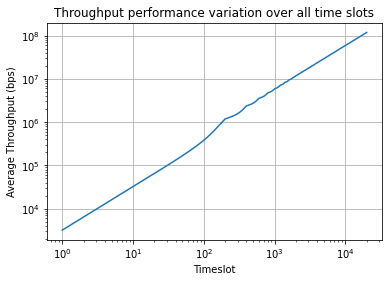

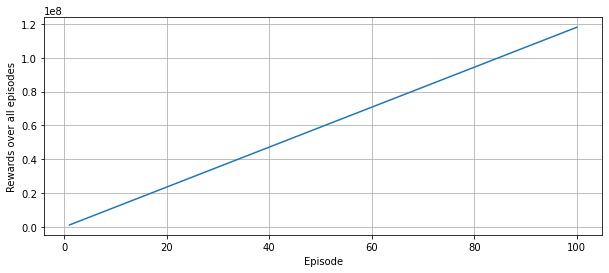

In [17]:
#timeslot = np.arange(start=1,stop=20001,step=1)

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(all_epochs,rewards_all_steps) # reward over all time slots
ax1.set_xlabel(r'Timeslot')
#plt.xlim(19800,20000);
ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.set_ylabel(r'Average Throughput (bps)')
ax1.set_title('Throughput performance variation over all time slots')
plt.grid(True)

episode_ = list(range(1,101))

plt.figure(figsize=(10, 4))
plt.plot(episode_,rewards_all_episodes)
plt.xlabel('Episode')
#plt.xlim(0,20000);
ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
plt.ylabel(r'Rewards over all episodes')
plt.grid(True)
plt.show()

## Plots ##

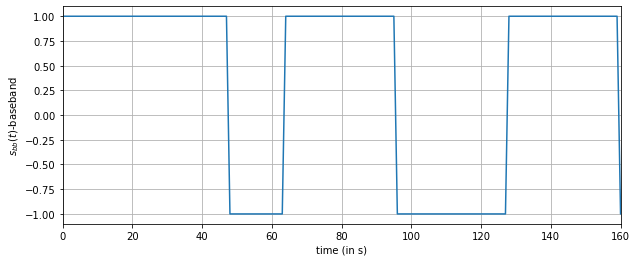

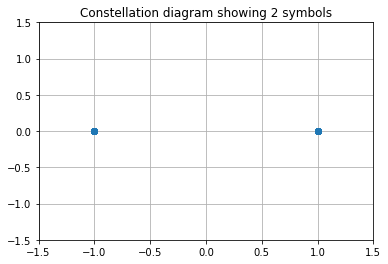

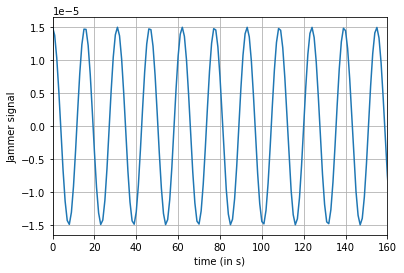

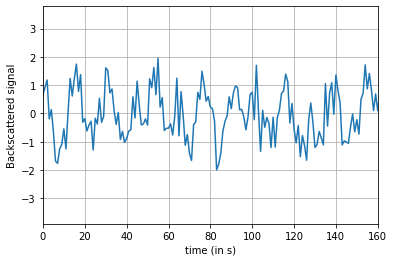

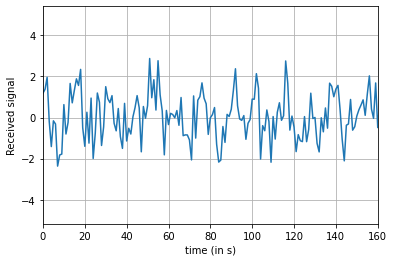

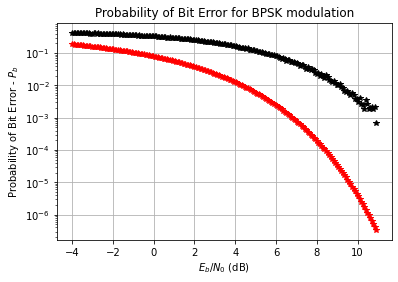

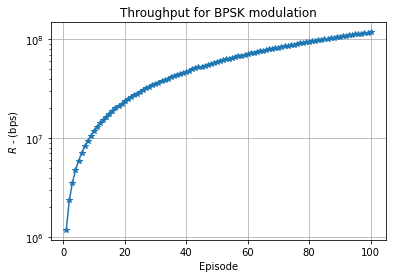

In [269]:
#plotting the baseband signal
plt.figure(figsize=(10, 4))
plt.plot(t,s_bb) # baseband wfm zoomed to first 10 bits
plt.xlabel('time (in s)')
plt.xlim(0,10*L);
plt.ylabel(r'$s_{bb}(t)$-baseband')
plt.grid(True)
plt.show()

#signal constellation at transmitter
plt.plot(np.real(s_bb),np.imag(s_bb),'o')
plt.xlim(-1.5,1.5) 
plt.ylim(-1.5,1.5)
plt.title('Constellation diagram showing 2 symbols')
plt.grid(True)
plt.show()

#plotting the jammer signal
plt.plot(t,Jammer(f_k,1)) # transmitted wfm zoomed to first 10 bits #Plot jammer only when jammer is present, so K_J = 1
plt.xlabel('time (in s)') 
plt.xlim(0,10*L)
plt.ylabel('Jammer signal')
plt.grid(True)
plt.show()

#plotting the bandpass signal
plt.plot(t,s_BD) # transmitted wfm zoomed to first 10 bits
plt.xlabel('time (in s)') 
plt.xlim(0,10*L)
plt.ylabel('Backscattered signal')
plt.grid(True)
plt.show()

# Received signal waveform zoomed to first 10 bits
plt.plot(t,y_AP) # received signal (with noise)
plt.xlabel('time (in s)')
plt.ylabel('Received signal')
plt.xlim(0,10*L)
plt.grid(True)
plt.show()

EbN0dB_per_episode = np.arange(start=-4,stop = 11,step = (11+4)/(num_episodes))
#------Theoretical Bit/Symbol Error Rates-------------
theoreticalBER = 0.5*erfc(np.sqrt(10**(EbN0dB/10))) # BER = (1/2)*erfc(sqrt(Eb/N0)) = Q(sqrt(2Eb/N0))
#-------------Plots---------------------------
fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(EbN0dB,BER,'k*',label='Simulated') # simulated BER
ax1.semilogy(EbN0dB,theoreticalBER,'r*',label='Theoretical')
ax1.set_xlabel(r'$E_b/N_0$ (dB)')
ax1.set_ylabel(r'Probability of Bit Error - $P_b$')
ax1.set_title('Probability of Bit Error for BPSK modulation')
plt.grid(True)

episode_ = np.arange(start = 1,stop=101, step =1)
fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(episode_,rewards_all_episodes,'-*',label='Simulated') # simulated BER
#ax1.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
#ax1.set_yscale('log', base=2)
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)

#fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
#ax1.semilogy(step,E_B,'k*',label='Simulated') # simulated BER
#ax1.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
#ax1.set_xlabel(r'Time Slot')
#ax1.set_ylabel(r'E_B - $units$')
#ax1.set_title('BD Battery State over all time slots')
#plt.grid(True)

NameError: name 'rewards_all_episodes' is not defined

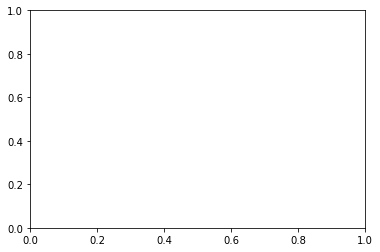

In [15]:
#Plotting average throughput over 100 episodes
episode_ = np.arange(start = 1,stop=101, step =1)
fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(episode_,rewards_all_episodes,'-*',label='Simulated') # simulated BER
#ax1.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
#ax1.set_yscale('log', base=2)
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps/Hz)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)

plt.savefig('avg_throughput_all_episodes.png')

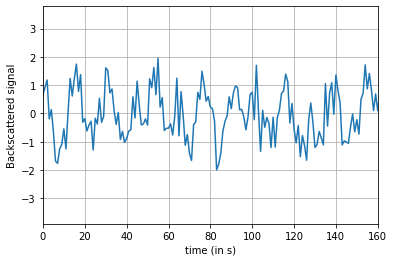

<Figure size 432x288 with 0 Axes>

In [273]:
#plotting the bandpass signal
plt.plot(t,s_BD) # transmitted wfm zoomed to first 10 bits
plt.xlabel('time (in s)') 
plt.xlim(0,10*L)
plt.ylabel('Backscattered signal')
plt.grid(True)
plt.show()

plt.savefig('backscattered_signal.png')


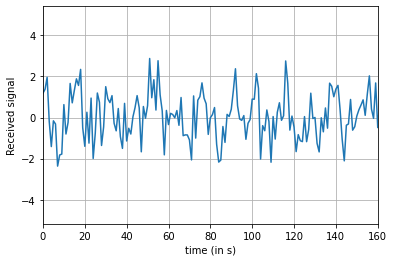

<Figure size 432x288 with 0 Axes>

In [274]:
# Received signal waveform zoomed to first 10 bits
plt.plot(t,y_AP) # received signal (with noise)
plt.xlabel('time (in s)')
plt.ylabel('Received signal')
plt.xlim(0,10*L)
plt.grid(True)
plt.show()

plt.savefig('received_signal.png')

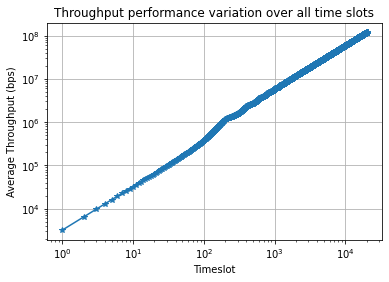

In [19]:
fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(all_epochs,rewards_all_steps,'-*') # reward over all time slots
ax1.set_xlabel(r'Timeslot')
#plt.xlim(19800,20000);
ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.set_ylabel(r'Average Throughput (bps)')
ax1.set_title('Throughput performance variation over all time slots')
plt.grid(True)

plt.savefig('avg_throughput_all_timeslots.png')

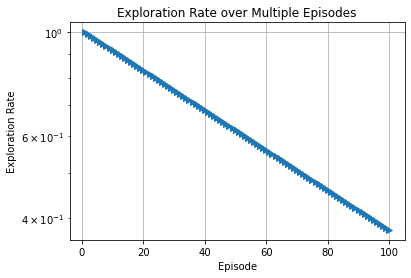

In [287]:
#Plotting exploration rate over 100 episodes
episode_ = np.arange(start = 1,stop=101, step =1)
fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(episode_,all_exploration_rate,'->',label='Simulated') # simulated BER
#ax1.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
ax1.set_yscale('log', base=10)
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Exploration Rate')
ax1.set_title('Exploration Rate over Multiple Episodes')
plt.grid(True)

plt.savefig('exploration_rate.png')

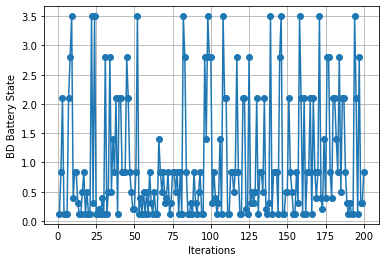

<Figure size 432x288 with 0 Axes>

In [343]:
#Plotting BD battery state over 100 episodes
episode_ = np.arange(start = 1,stop=201, step =1)
#fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
#ax1.semilogy(episode_,E_B,'o-',label='Simulated') 
#ax1.set_yscale('log', base=2)
#ax1.set_xlabel(r'Step')
#ax1.set_ylabel(r'BD Battery State')
#ax1.set_title('Distribution of BD Battery Energy')
#plt.grid(True)

plt.plot(episode_,E_B,'o-') 
plt.xlabel('Iterations')
plt.ylabel('BD Battery State')
#plt.xlim(0,10*L)
plt.grid(True)
plt.show()

plt.savefig('bd_bat_energy.png')

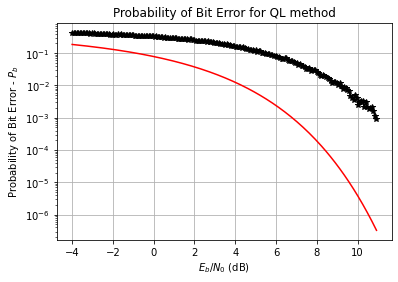

In [320]:
EbN0dB_per_episode = np.arange(start=-4,stop = 11,step = 2)
#------Theoretical Bit/Symbol Error Rates-------------
theoreticalBER = 0.5*erfc(np.sqrt(10**(EbN0dB_per_episode/10))) # BER = (1/2)*erfc(sqrt(Eb/N0)) = Q(sqrt(2Eb/N0))
#-------------Plots---------------------------
fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(EbN0dB_per_episode,BER,'k-*',label='Simulated') # simulated BER
ax1.semilogy(EbN0dB_per_episode,theoreticalBER,'r-',label='Theoretical')
ax1.set_xlabel(r'$E_b/N_0$ (dB)')
ax1.set_ylabel(r'Probability of Bit Error - $P_b$')
ax1.set_title('Probability of Bit Error for QL method')
plt.grid(True)

#plt.savefig('BER_Qlearning.png')